# Fine Tune

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import torch
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset

import tqdm as tqdm

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Dataset

In [2]:
mbti_df = pd.read_csv('../processed/all_data_3.csv')

In [3]:
mbti_df

,Unnamed: 0,type,tweet
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl..."
1,1,ISFJ,Tinder has your health in mind.
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker
3,3,ISFJ,Outstanding faculty from and more at Winter Co...
4,4,ISFJ,"Using pray and wait on God, can be a means of ..."
...,...,...,...
106322,106322,ESTP,This is so legit holy shit lol I work in rando...
106323,106323,ESTP,Same here When Im in a group Im fairly quiet u...
106324,106324,ESTJ,Im more worried about the idea that we are sla...
106325,106325,ESTP,Believing you dont have ethics is still an eth...


### Add column `introvert_extrovert`

In [4]:
mbti_df['perceiving_judging'] = mbti_df['type'].apply(lambda x: 'Perceiving' if x[3] == 'P' else 'Judging')

In [5]:
mbti_df.sample(10)

,Unnamed: 0,type,tweet,perceiving_judging
10454,10454,ENFP,gt the whole demographic is inherently dumb or...,Perceiving
62799,62799,INTP,No its not If you think Redpill summarizes all...,Perceiving
59944,59944,INTP,I get that more from other Chinese particularl...,Perceiving
54784,54784,INTJ,Its only stiff and awkward if you think of it ...,Judging
12258,12258,ENFP,do you see how limited you are in your view yo...,Perceiving
79890,79890,ISTJ,Loud music usually doesnt bother me Many times...,Judging
105250,105250,ESTP,I learned about it in a college class and then...,Perceiving
79197,79197,ISTJ,Ive not heard of it but have just checked it o...,Judging
6445,6445,ENFJ,Annoying article as a whole Theres so much dis...,Judging
97299,97299,ISFJ,i do find it amusing how almost no one has rea...,Judging


### Consider only posts with length < 32 words

In [6]:
mbti_df = mbti_df[mbti_df['tweet'].str.split().str.len() < 32]

In [7]:
mbti_df

,Unnamed: 0,type,tweet,perceiving_judging
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl...",Judging
1,1,ISFJ,Tinder has your health in mind.,Judging
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker,Judging
3,3,ISFJ,Outstanding faculty from and more at Winter Co...,Judging
4,4,ISFJ,"Using pray and wait on God, can be a means of ...",Judging
...,...,...,...,...
106313,106313,ESTP,True I do end up the mentor but I feel like Yo...,Perceiving
106321,106321,ESFP,LOL and thats why I got sort of mad because th...,Perceiving
106322,106322,ESTP,This is so legit holy shit lol I work in rando...,Perceiving
106324,106324,ESTJ,Im more worried about the idea that we are sla...,Judging


In [8]:
mbti_df = mbti_df.drop(columns=['Unnamed: 0'])

In [9]:
mbti_df.sample(10)

,type,tweet,perceiving_judging
62240,INTP,a few more i liked this one because of the cap...,Perceiving
75838,ISTJ,just a general question how important is a cle...,Judging
62894,INTP,feeling at peace with ones self at least thats...,Perceiving
100907,ESFJ,Im on Facebook way too much for my own good Ge...,Judging
19141,ENTJ,Correct me if Im wrong but I thought each ques...,Judging
98495,ISFJ,Ok from what im getting you are some sort of E...,Judging
64084,INTP,Lol sounds much like the relationship between ...,Perceiving
20067,ENTJ,has there ever been a moment in which you just...,Judging
23955,ENTJ,especially philosophy who are as dedicated to ...,Judging
55435,INTJ,going by the dictionary definitiona person who...,Judging


C:\Users\fizuf\AppData\Local\Temp\ipykernel_3316\3459639367.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mbti_df_grouped, x='perceiving_judging', y='n_posts', palette='husl')


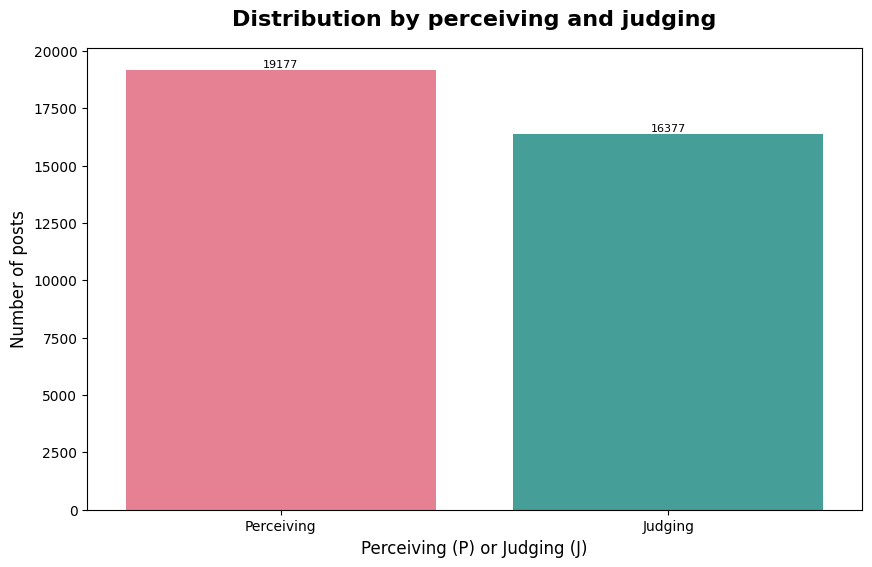

In [10]:
mbti_df_grouped = mbti_df.groupby('perceiving_judging').size().reset_index(name='n_posts')
mbti_df_grouped = mbti_df_grouped.sort_values(by='n_posts', ascending=False)
mbti_df_grouped.columns = ['perceiving_judging', 'n_posts']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mbti_df_grouped, x='perceiving_judging', y='n_posts', palette='husl')

# Add annotations (number of users above each bar)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=8, color='black')

plt.title('Distribution by perceiving and judging', fontsize=16, fontweight='bold', pad=16)
plt.xlabel('Perceiving (P) or Judging (J)', fontsize=12)
plt.ylabel('Number of posts', fontsize=12)

plt.show()

In [11]:
mbti_labels_dict = {
    'Perceiving': 0,
    'Judging': 1,
}

### Split datasets

In [12]:
X = mbti_df['tweet']
y = mbti_df['perceiving_judging']

y = y.map(mbti_labels_dict)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


### Fine Tune BERT

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  
model.config.hidden_dropout_prob = 0.3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
inputs = tokenizer(X.tolist(), padding=True, truncation=True, max_length=32, return_tensors='pt')
labels = torch.tensor(y.values) 

train_dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [17]:
import joblib

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

losses = []
acc = []
prec = []
recalls = []
f1score = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Track predictions and labels
        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(train_dataloader)

    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
    
    # Calculate metrics (accuracy, precision, recall, F1-score)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    acc.append(accuracy)
    prec.append(precision)
    recalls.append(recall)
    f1score.append(f1)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


joblib.dump(model, 'data/model_6.joblib')
joblib.dump(tokenizer, 'data/tokenizer_6.joblib')

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: 0.6868187478698005
Accuracy: 0.5484, Precision: 0.5411, Recall: 0.5484, F1-Score: 0.5191
Epoch 2/10, Loss: 0.6612703315434848
Accuracy: 0.6013, Precision: 0.6010, Recall: 0.6013, F1-Score: 0.5886
Epoch 3/10, Loss: 0.5762619432780154
Accuracy: 0.6986, Precision: 0.6987, Recall: 0.6986, F1-Score: 0.6962
Epoch 4/10, Loss: 0.3856147772424249
Accuracy: 0.8271, Precision: 0.8271, Recall: 0.8271, F1-Score: 0.8267
Epoch 5/10, Loss: 0.20682585148911703
Accuracy: 0.9178, Precision: 0.9178, Recall: 0.9178, F1-Score: 0.9177
Epoch 6/10, Loss: 0.12541917098011549
Accuracy: 0.9532, Precision: 0.9532, Recall: 0.9532, F1-Score: 0.9532
Epoch 7/10, Loss: 0.08590334757071966
Accuracy: 0.9677, Precision: 0.9677, Recall: 0.9677, F1-Score: 0.9677
Epoch 8/10, Loss: 0.0664278767377292
Accuracy: 0.9746, Precision: 0.9746, Recall: 0.9746, F1-Score: 0.9746
Epoch 9/10, Loss: 0.057627128387894425
Accuracy: 0.9774, Precision: 0.9774, Recall: 0.9774, F1-Score: 0.9774
Epoch 10/10, Loss: 0.04926607361

['data/tokenizer_6.joblib']

In [31]:
import joblib

joblib.dump(model, 'data/model_3.joblib')
joblib.dump(tokenizer, 'data/tokenizer_3.joblib')

['data/tokenizer_3.joblib']

### Loss

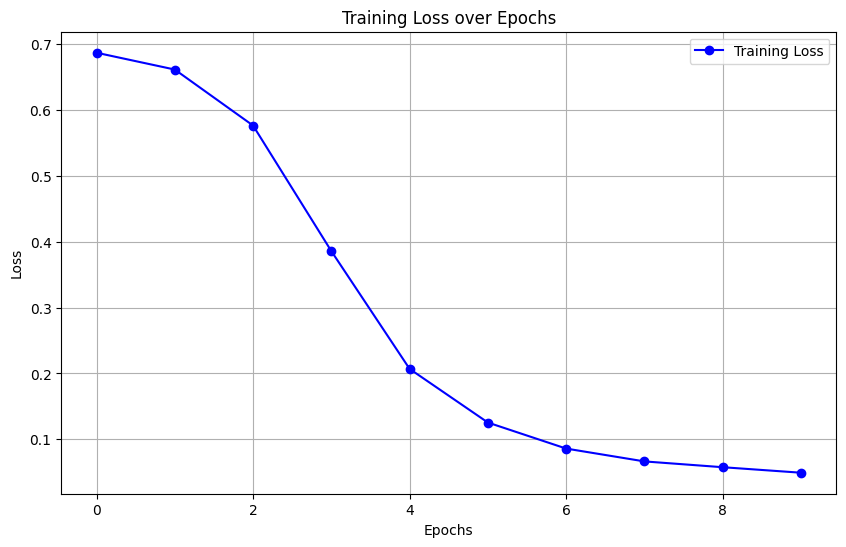

In [18]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(losses, label='Training Loss', color='b', marker='o')  # Plot losses
plt.title('Training Loss over Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show gridlines for better readability
plt.show()  # Display the plot

### Accuracy, precision, recall, and f1-score

In [19]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(all_preds, all_labels))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13365
           1       0.98      0.98      0.98     11522

    accuracy                           0.98     24887
   macro avg       0.98      0.98      0.98     24887
weighted avg       0.98      0.98      0.98     24887



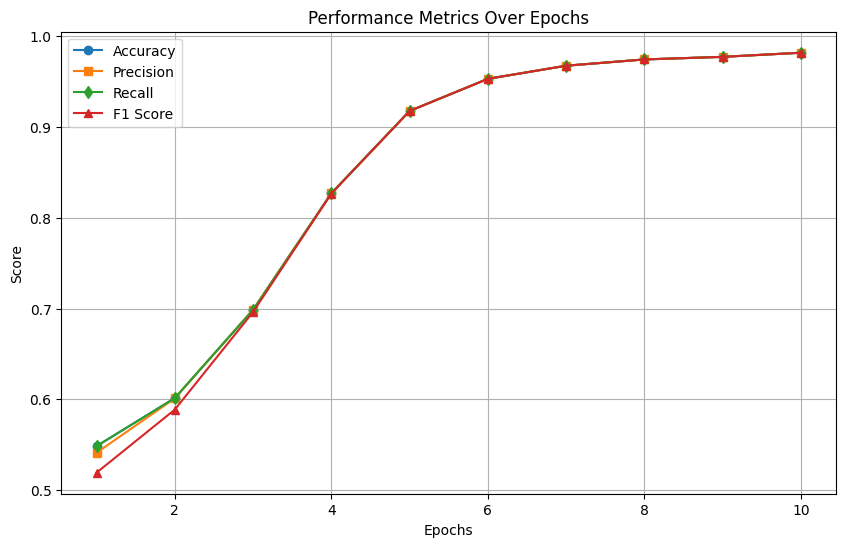

In [20]:
epochs = range(1, len(acc) + 1)

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Accuracy', marker='o')
plt.plot(epochs, prec, label='Precision', marker='s')
plt.plot(epochs, recalls, label='Recall', marker='d')
plt.plot(epochs, f1score, label='F1 Score', marker='^')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Performance Metrics Over Epochs')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Evaluation

In [2]:
import joblib 

model = joblib.load('data/model_2.joblib')
tokenizer = joblib.load('data/tokenizer_2.joblib')

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import torch

model.eval()  # Set model to evaluation mode

val_preds = []
val_labels = []
all_attentions = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions
        all_attentions.append(attentions)
        logits = outputs.logits
        preds = logits.argmax(dim=-1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
                        
    # Validation metrics
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

    print(f"Testing - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

# Print classification report using val_preds and val_labels
print(classification_report(val_labels, val_preds))


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Testing - Accuracy: 0.5291, Precision: 0.5419, Recall: 0.5291, F1-Score: 0.5270
              precision    recall  f1-score   support

           0       0.59      0.45      0.51      5813
           1       0.49      0.62      0.55      4854

    accuracy                           0.53     10667
   macro avg       0.54      0.54      0.53     10667
weighted avg       0.54      0.53      0.53     10667



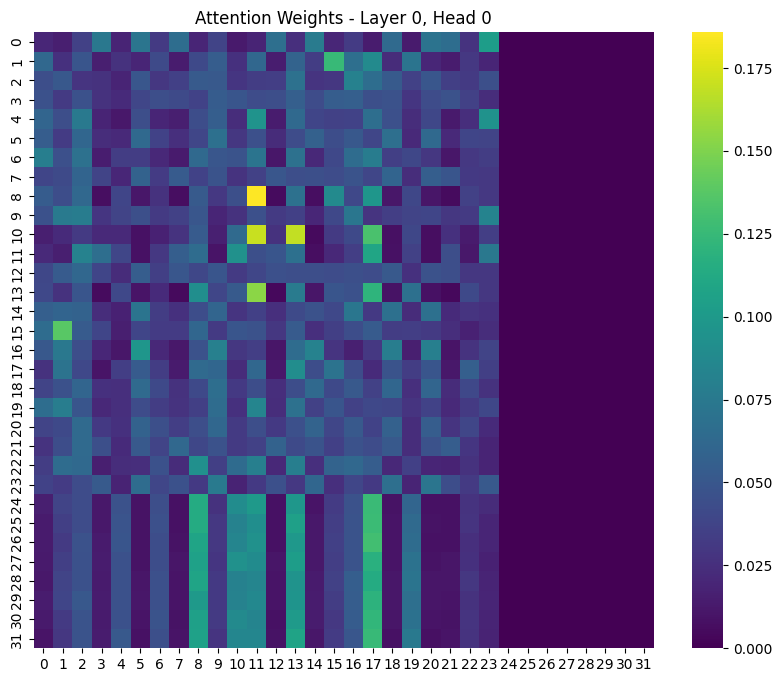

In [22]:
layer = 0  # First layer
head = 0   # First attention head
attention_weights = attentions[layer][0, head].cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, annot=False, cmap='viridis')
plt.title(f"Attention Weights - Layer {layer}, Head {head}")
plt.show()